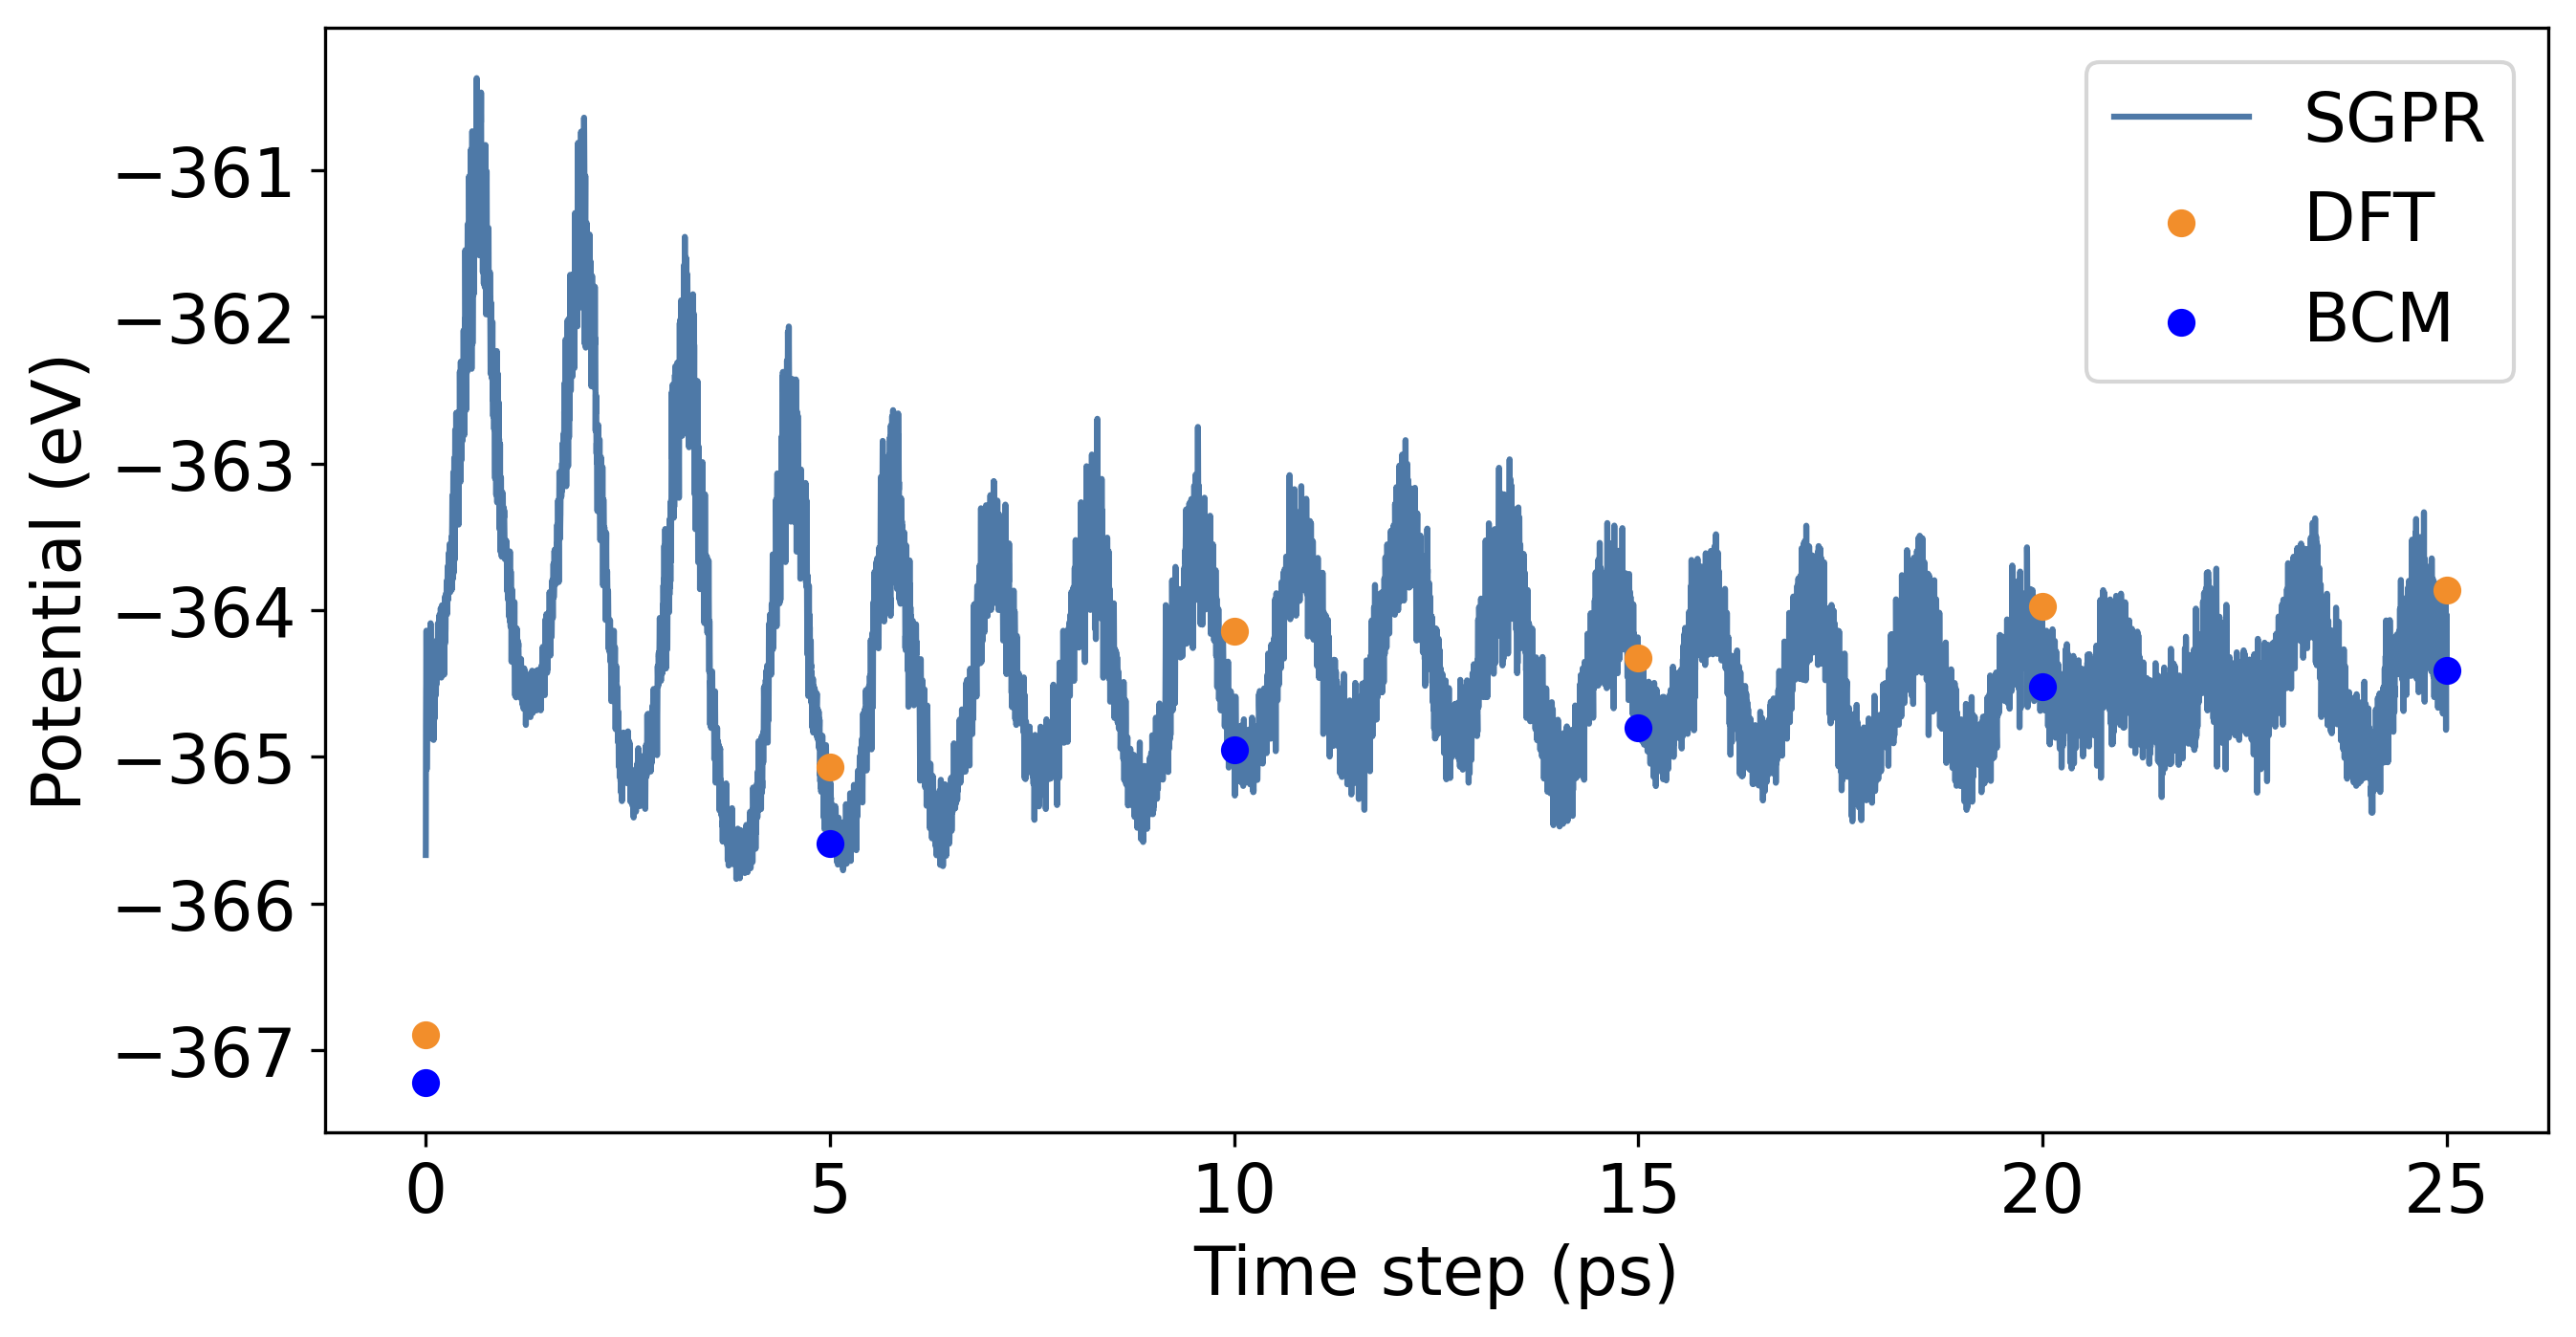

In [2]:
import datetime
import matplotlib.pyplot as plt
import numpy as np

def timestamp(string=None, fmt="%m/%d/%Y %H:%M:%S"):
    if string is not None:
        d = datetime.datetime.strptime(string, fmt)
    else:
        d = datetime.datetime.now()
    return d.timestamp()

def parse_logfile(file="active.log", window=(None, None)):
    start = None
    settings = []
    elapsed = []
    energies = []
    temperatures = []
    covloss = []
    exact_energies = []
    test_energies = []
    meta = []
    
    for line in open(file):
        if line.startswith("#"):
            continue

        s = line.split()
        ts = timestamp(" ".join(s[:2]))
        if start is None:
            start = ts
        ts = (ts - start) / 60
        split = s[2:]

        if split[1] == "settings:":
            settings = {}
            b = None
            for a in split[2:]:
                if ":" in a:
                    settings[a] = ""
                    b = a
                else:
                    settings[b] += a
            settings = {a: eval(b) for a, b in settings.items()}

        try:
            step = int(split[0])
            if window[0] and step < window[0]:
                continue
            if window[1] and step > window[1]:
                break
        except IndexError:
            continue

        elapsed += [(step, ts)]

        try:
            energies += [(step, float(split[1]))]
            temperatures += [(step, float(split[2]))]
            covloss += [(step, float(split[3]))]
        except:
            pass

        if "meta:" in split:
            meta += [(step, float(split[split.index("meta:") + 1]))]

        if "exact energy" in line:
            exact_energies += [(step, float(split[3]))]

        if "testing energy" in line:
            test_energies += [(step, float(split[3]))]

    return energies, exact_energies, test_energies

# Extend xenergy to contain 6 values and adjust yenergy, yenergy2 to have 6 points
xenergy = np.linspace(0, 25, 6)
yenergy = [-366.89363, -365.06611, -364.14303, -364.32358, -363.97578, -363.86061]
yenergy2 = [-367.218803436232, -365.58934317699, -364.94923209823, -364.800493135505, -364.523097733011, -364.413097556264]

def log_to_figure(file, figsize=(10, 5), window=(None, None)):
    ml, fp, test = parse_logfile(file, window=window)

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    x_ml, y_ml = zip(*ml)

    # Scaling factor for time steps
    scaling_factor = 25 / 100000
    x_ml_scaled = [x * scaling_factor for x in x_ml]

    ax.plot(x_ml_scaled, y_ml, label="SGPR", zorder=1, color='#4e79a7')
    
    if fp:
        x_fp, y_fp = zip(*fp)
        ax.scatter(x_fp, y_fp, color="red", label="ab initio", zorder=2)
    
    if test:
        x_test, y_test = zip(*test)
        ax.scatter(x_test, y_test, color="green", label="test", zorder=2)

    # Plot DFT and BCM calculations
    ax.scatter(xenergy, yenergy, color='#f28e2b', label='DFT', zorder=2)
    ax.scatter(xenergy, yenergy2, color='blue', label='BCM', zorder=2)  # New yenergy2 plot

    ax.set_ylabel("Potential (eV)")
    ax.set_xlabel("Time step (ps)")
    plt.rc('font', size=17)
    ax.legend()

    plt.show()

log_to_figure('../Data/Fig.4/active.log')
